# 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection
Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year.

In [1]:
"""This notebook contains the code for best subset selection, 
so this notebook may take longer time to run, for faster run, make
max_feature  into a smaller number"""
max_feature = 3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model


In [2]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA') # Salary column has "NA" when values are not available.

print (list(Hitters)) # get the header of this data

print (Hitters.shape) # get the dimension of this 

Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
print (np.sum(pd.isnull(Hitters['Salary']))) # number of NAs in Salary column'
print (Hitters['Salary'].isnull().sum())

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
                                                  #  without adding a new column index

print (Hitters['Salary'].isnull().sum())
print(Hitters.shape)

59
59
0
(263, 20)


In [4]:
y = Hitters.Salary  # the response variable 

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print (dummies.head())

X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64') 
# Note: axis=1 denotes that we are referring to a column, not a row
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [5]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_A,Division_E,NewLeague_A
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,0,0,0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,1,0,1
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,0,1,0
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,0,1,0
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,1,0,1


In [16]:
"""
Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    #print("feature_list: ", list(feature_list))
    X = sm.add_constant(X[list(feature_list)]) # add constant for intercept; list(): convert tuple to list
    model = sm.OLS(y, X).fit()  
    RSS = ((model.predict(X) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K): # e.g., combinations([A,B,C,D], 2) --> (A,B), (A,C), (A,D)
                                                   #                                      (B,C), (B,D), (C,D)
        #print("c: ", c)
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    #print(model_all)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] 
    #print(best_model)
    # idxmin() returns index of first occurrence of minimum of values.
    # this could be modified to have the top several models
    return best_model

In [17]:
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, just run from 1 to max_fearure features: [1,2,3] 
    models.loc[i] = bestModel(y, X, i)
    
models

,RSS,Model
1,3.617968e+07,<statsmodels.regression.linear_model.Regressio...
2,3.064656e+07,<statsmodels.regression.linear_model.Regressio...
3,2.924930e+07,<statsmodels.regression.linear_model.Regressio...


In [18]:
print (models.loc[2, 'Model'].summary())
# this summay confirms that the best two variable model contains the variables Hits and CRBI

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     96.17
Date:                Thu, 20 Sep 2018   Prob (F-statistic):           5.43e-32
Time:                        17:27:28   Log-Likelihood:                -1907.2
No. Observations:                 263   AIC:                             3820.
Df Residuals:                     260   BIC:                             3831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.9559     55.982     -0.857      0.3

In [19]:
print (models.loc[3, 'Model'].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     71.05
Date:                Thu, 20 Sep 2018   Prob (F-statistic):           1.48e-33
Time:                        17:28:47   Log-Likelihood:                -1901.1
No. Observations:                 263   AIC:                             3810.
Df Residuals:                     259   BIC:                             3825.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -71.4592     55.203     -1.294      0.1

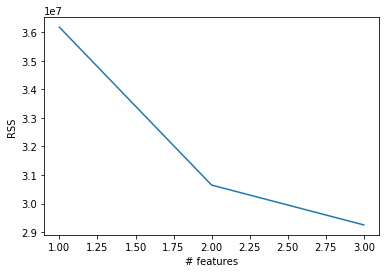

In [20]:
""" this shows an example to plot the RSS of best models with different number of parameters"""
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [21]:
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) # axis 1: apply function to each row
# find the adjust R^2, use dir() to identify all available attributes

In [22]:
rsquared_adj

1    0.318850
2    0.420802
3    0.445075
dtype: float64

In [23]:
print(models.loc[1, 'Model'].rsquared_adj)

0.3188502805784996


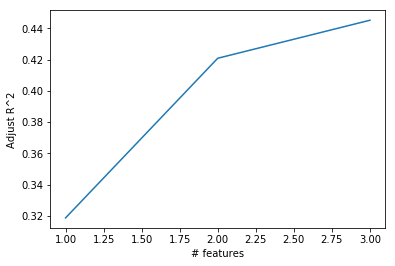

In [24]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

### Forward Stepwise Selection

In [33]:
"""
We can use the previous user defined function 'def getRSS(y, X, feature_list)' to add 1 feature at a time (start from 0 feature) for forward stepwise selection
or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
"""
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    #print(remaining_predictors)
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [35]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):   # from 1 to 19
    models2.loc[i] = forward_select(y, X, feature_list)
    #print(feature_list)
    feature_list = list(models2.loc[i]["Model"].model.exog_names) # selected features in models2.loc[i]
    #print(feature_list)
    if 'const' in feature_list:
        feature_list.remove('const')

models2

,RSS,Model
1,3.617968e+07,<statsmodels.regression.linear_model.Regressio...
2,3.064656e+07,<statsmodels.regression.linear_model.Regressio...
3,2.924930e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797085e+07,<statsmodels.regression.linear_model.Regressio...
5,2.714990e+07,<statsmodels.regression.linear_model.Regressio...
6,2.619490e+07,<statsmodels.regression.linear_model.Regressio...
7,2.595422e+07,<statsmodels.regression.linear_model.Regressio...
8,2.515923e+07,<statsmodels.regression.linear_model.Regressio...
9,2.481405e+07,<statsmodels.regression.linear_model.Regressio...
10,2.450040e+07,<statsmodels.regression.linear_model.Regressio...


In [36]:
"""we can compare the results of best subset selection and the forward selection"""
print('Best max_feature (set to 3) variable from best subset selection on tranining')
print (models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print (models2.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
const     -71.459220
Hits        2.803816
CRBI        0.682528
PutOuts     0.273581
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
const     -71.459220
CRBI        0.682528
Hits        2.803816
PutOuts     0.273581
dtype: float64


In [37]:
models2.loc[max_feature, "Model"].model.exog_names

['const', 'CRBI', 'Hits', 'PutOuts']

### Backward Stepwise Selection

In [45]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        #print(combo)
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [50]:
"""
The backward selection starts from all the variables of features
"""
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)+1))
feature_list = X.columns
models3.loc[len(feature_list)] = getRSS(y, X, feature_list) # model with the full features

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = list(models3.loc[len(feature_list)-1]["Model"].model.exog_names) # copy, instead of assigning an address pointer
    if 'const' in feature_list:
        feature_list.remove('const')

print (models3.loc[max_feature, "Model"].params)

const     -79.396905
Hits        2.643199
CRuns       0.664893
PutOuts     0.310056
dtype: float64


In [51]:
models3

,RSS,Model
1,3.6438e+07,<statsmodels.regression.linear_model.Regressio...
2,3.12035e+07,<statsmodels.regression.linear_model.Regressio...
3,2.94073e+07,<statsmodels.regression.linear_model.Regressio...
4,2.84508e+07,<statsmodels.regression.linear_model.Regressio...
5,2.75095e+07,<statsmodels.regression.linear_model.Regressio...
6,2.66741e+07,<statsmodels.regression.linear_model.Regressio...
7,2.59335e+07,<statsmodels.regression.linear_model.Regressio...
8,2.51592e+07,<statsmodels.regression.linear_model.Regressio...
9,2.48141e+07,<statsmodels.regression.linear_model.Regressio...
10,2.45004e+07,<statsmodels.regression.linear_model.Regressio...


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

### In previous sections, we defined the 'best' model based on some statistics (R^2, adj R^2, AIC, BIC, etc) of the training dataset. This may cause 'overfitting' problem which means the best model on training data can not generalize well to new data. In this section, validation approach will be discussed.

### Validation Set Approach and best subset selection / Validation Set Approach and forward selection

In [53]:
# Randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set.
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [54]:
train_index

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False, False,  True,
        True, False,  True, False,  True, False, False,  True,  True,
       False,  True,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,

In [55]:
sum(train_index)

171

In [56]:
sum(test_index)

92

In [57]:
test_index

array([False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True, False,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False, False, False, False,  True, False,  True,  True, False,
       False,  True, False,  True, False,  True,  True, False, False,
        True, False, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True,

In [58]:
""" We can recyle the old functions. Modification is needed to compute the RSS for the testing data. 
So we need to add both train and test into the function input
"""
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    
    X_train = sm.add_constant(X_train[list(feature_list)])
    X_test = sm.add_constant(X_test[list(feature_list)])
    model = sm.OLS(y_train, X_train).fit()
    RSS = ((model.predict(X_test) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [59]:
models_validation= pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, just run from 1 to max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 

In [60]:
"""change the function to  forward_select_validation (.) or backward_select_validation(.) 
for forward selection or backward selection""" 
    
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = list(models2_forward.loc[i]["Model"].model.exog_names)  
    if 'const' in feature_list:
        feature_list.remove('const')

In [65]:
print('Best max_feature variables from best subset selection on tranining')
print (models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variables from forward selection on tranining')
print (models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variables from backward selection on tranining')
print (models3.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variables from best subset selection on traning and validation split')
print (models_validation.loc[max_feature, 'Model'].params)

Best max_feature variables from best subset selection on tranining
const     -71.459220
Hits        2.803816
CRBI        0.682528
PutOuts     0.273581
dtype: float64

---------------------------------------------
Best max_feature variables from forward selection on tranining
const     -71.459220
CRBI        0.682528
Hits        2.803816
PutOuts     0.273581
dtype: float64

---------------------------------------------
Best max_feature variables from backward selection on tranining
const     -79.396905
Hits        2.643199
CRuns       0.664893
PutOuts     0.310056
dtype: float64

---------------------------------------------
Best max_feature variables from best subset selection on traning and validation split
const     86.741421
AtBat     -1.170621
Hits       6.639760
CHmRun     2.838581
dtype: float64


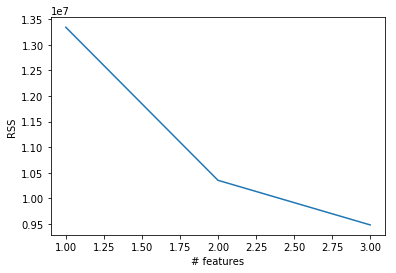

In [62]:
""" this shows an example to plot the RSS of best models with different number of parameters for best subset with validation"""
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

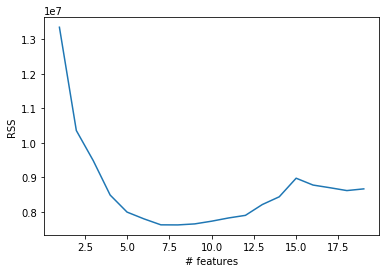

In [63]:
""" this shows an example to plot the RSS of best models with different number of parameters for forward selection with validation"""
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

# From graph below, 7 variables model gives us the best RSS under forward selection. 
# To learn the final model, it is also recommendated to re-train the model on entire data (train + validation).

In [64]:
print('Best 7 feature variables from forward selection on traning and validation split')
print (models2_forward.loc[7, 'Model'].params)

Best 7 feature variables from forward selection on traning and validation split
const           4.853118
Hits            6.747954
CHmRun          2.671643
AtBat          -1.436817
PutOuts         0.208452
Division_E    100.684656
Walks           3.558943
HmRun          -5.865539
dtype: float64


### Cross-Validation

In [70]:
"""This approach is similar to the previous validation idea. 
The difference is that we break the entire dataset into K different folds. 
Each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold.
Advantages: 
1. There will be multiple metrics out of testing results => distribution of testing RSS, etc.
2. The size of traning dataset is much closer to the size of original dateset. This will remove some biases caused by
the size difference."""

k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [71]:
train_index

array([9, 8, 4, 0, 0, 8, 3, 2, 1, 8, 9, 6, 0, 4, 6, 4, 4, 7, 8, 9, 5, 6,
       5, 2, 6, 2, 8, 2, 0, 5, 5, 0, 3, 0, 8, 1, 0, 2, 6, 4, 9, 0, 0, 5,
       5, 9, 6, 3, 4, 6, 9, 0, 0, 0, 9, 5, 2, 9, 7, 1, 8, 2, 7, 8, 9, 0,
       9, 7, 5, 2, 7, 5, 0, 4, 2, 2, 0, 9, 1, 0, 3, 1, 3, 1, 1, 6, 0, 2,
       6, 9, 1, 3, 1, 1, 1, 1, 1, 6, 5, 7, 5, 4, 6, 1, 9, 1, 3, 6, 8, 1,
       9, 1, 0, 9, 8, 3, 9, 4, 0, 2, 9, 0, 8, 1, 1, 4, 6, 8, 5, 0, 3, 5,
       7, 0, 8, 5, 3, 7, 7, 5, 3, 2, 2, 0, 9, 2, 2, 6, 6, 3, 5, 1, 5, 6,
       1, 4, 3, 6, 5, 3, 3, 2, 7, 0, 5, 4, 1, 5, 0, 7, 2, 8, 1, 3, 2, 7,
       2, 0, 5, 7, 1, 9, 7, 4, 6, 0, 1, 1, 5, 6, 6, 5, 9, 3, 3, 5, 7, 9,
       9, 0, 2, 3, 3, 9, 9, 6, 8, 5, 2, 1, 8, 5, 6, 6, 8, 6, 1, 2, 5, 1,
       8, 7, 2, 7, 4, 3, 8, 8, 0, 1, 5, 6, 3, 9, 9, 1, 6, 1, 7, 5, 1, 6,
       3, 6, 1, 1, 6, 7, 6, 5, 7, 2, 9, 9, 1, 5, 7, 7, 5, 2, 3, 5, 7])

In [82]:
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        cv_errors.loc[i][j] = models_cv.loc[i]["RSS"]
        # cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = list(models_cv.loc[i]["Model"].model.exog_names)
        if 'const' in feature_list:
            feature_list.remove('const')

In [83]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,4.93184e+06,7.10438e+06,3.16742e+06,2.05858e+06,1.4284e+06,3.50107e+06,2.8317e+06,3.94287e+06,847315,2.18828e+06
2,3.79019e+06,6.61835e+06,2.70241e+06,1.26404e+06,1.02146e+06,2.34512e+06,1.53599e+06,3.43583e+06,674147,1.92477e+06
3,3.38535e+06,6.54667e+06,2.35399e+06,1.15313e+06,954027,2.10271e+06,1.42114e+06,3.41546e+06,622597,1.3858e+06
4,3.17359e+06,6.50647e+06,2.13645e+06,1.10796e+06,882165,1.71471e+06,1.37753e+06,3.42067e+06,555795,1.33792e+06
5,2.9704e+06,6.505e+06,1.83527e+06,1.11697e+06,854810,1.65792e+06,1.36707e+06,3.45916e+06,506614,1.29904e+06
6,2.81353e+06,6.53617e+06,1.77397e+06,1.13938e+06,854634,1.62114e+06,1.19587e+06,3.52621e+06,499261,1.33703e+06
7,2.70841e+06,6.57399e+06,1.756e+06,1.20057e+06,857892,1.60952e+06,1.15896e+06,3.54758e+06,491446,1.27279e+06
8,2.70034e+06,6.5924e+06,1.74936e+06,1.25183e+06,862361,1.60387e+06,1.15239e+06,3.66836e+06,469717,1.20757e+06
9,2.70006e+06,6.57384e+06,1.76282e+06,954891,897245,1.5986e+06,1.16517e+06,3.7958e+06,465031,1.20534e+06
10,2.70382e+06,6.42277e+06,1.78317e+06,823153,898931,1.59774e+06,1.18071e+06,3.81228e+06,464565,1.20626e+06


In [85]:
cv_errors.loc[1][2]

7104381.65149112

In [84]:
cv_errors[2][1]

7104381.65149112

In [86]:
models_cv

,RSS,Model
1,2.188281e+06,<statsmodels.regression.linear_model.Regressio...
2,1.924769e+06,<statsmodels.regression.linear_model.Regressio...
3,1.385795e+06,<statsmodels.regression.linear_model.Regressio...
4,1.337920e+06,<statsmodels.regression.linear_model.Regressio...
5,1.299044e+06,<statsmodels.regression.linear_model.Regressio...
6,1.337027e+06,<statsmodels.regression.linear_model.Regressio...
7,1.272794e+06,<statsmodels.regression.linear_model.Regressio...
8,1.207574e+06,<statsmodels.regression.linear_model.Regressio...
9,1.205335e+06,<statsmodels.regression.linear_model.Regressio...
10,1.206261e+06,<statsmodels.regression.linear_model.Regressio...


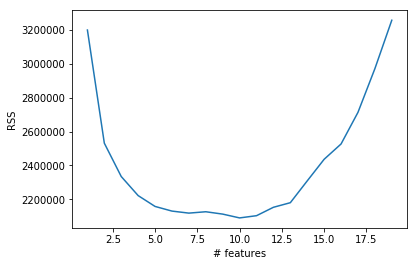

In [87]:
cv_errors_mean = cv_errors.mean(axis = 1) # mean of each row
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [88]:
cv_errors_mean

1     3.200187e+06
2     2.531230e+06
3     2.334087e+06
4     2.221326e+06
5     2.157225e+06
6     2.129719e+06
7     2.117716e+06
8     2.125820e+06
9     2.111880e+06
10    2.089340e+06
11    2.102477e+06
12    2.152166e+06
13    2.179314e+06
14    2.308332e+06
15    2.436054e+06
16    2.526459e+06
17    2.713446e+06
18    2.971609e+06
19    3.258086e+06
dtype: float64

In [89]:
"""From the above plot, we can see that the model with 10 variables yielded the smallest RSS.
We can take a closer look at that model summary. 
We can also see that the model performance for variables 4 - 12 are similar."""
print(models_cv.loc[10, "Model"].summary()) # model from 10th interation

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     22.86
Date:                Thu, 20 Sep 2018   Prob (F-statistic):           2.98e-29
Time:                        19:27:01   Log-Likelihood:                -1692.9
No. Observations:                 235   AIC:                             3408.
Df Residuals:                     224   BIC:                             3446.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7803     77.322     -0.062      0.9

In [90]:
models_cv.loc[10, "Model"].model.exog_names

['const',
 'PutOuts',
 'CHits',
 'CAtBat',
 'CRBI',
 'Assists',
 'Walks',
 'CWalks',
 'Division_E',
 'Years',
 'League_A']

## Feature Selection For Machine Learning in Python
https://machinelearningmastery.com/feature-selection-machine-learning-python/